In [1]:
SAVE = True

Combine relevant evaluation files into a single file

In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_VAR_10splits_valid_ratio/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_10splits_valid_ratio/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_10splits_valid_ratio/00_summary_7stepsahead_interv',
        ]    

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1])
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_valid_ratio_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_valid_ratio_ensemble.csv'))

Creating grand combined evaluation file                                                                                                                                                                 

See what the actual valid ratio is

In [3]:
combined_eval_file.groupby('data_dropout_to_level')['valid_training_data_ratio'].mean()

data_dropout_to_level
0.2    0.202808
0.3    0.303239
0.4    0.402863
0.5    0.501263
0.6    0.594612
0.7    0.671537
0.8    0.721972
Name: valid_training_data_ratio, dtype: float64

Calculate metrics and CIs

In [4]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, hyperparameters=['latent_model', 'data_dropout_to_level'], include_r2=False, only_nonzero_differences=False)

In [5]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
metrics['diff mae'] = m_manager.diff_mae(func='mean')
errorbars['diff mae'] = m_manager.diff_mae(func='sem')
metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')
metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')

Plot MAE

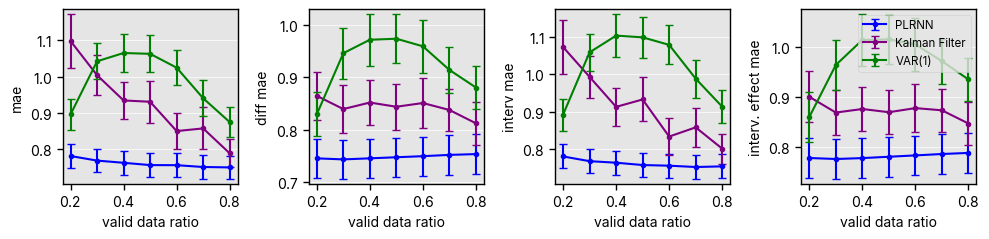

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim

model_labels = {
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'KalmanFilter': 'Kalman Filter',
                    'VAR1': 'VAR(1)'
                    }

with PaperStyle():

    fig, axes = plt.subplots(1, len(metrics), figsize=(10, 2.5), sharex=True)

    for i, m in enumerate(metrics):
        for j, model in enumerate(model_labels.keys()):
            # for mrt in MRT:
            this_line = metrics[m].loc[(model)]
            this_errorbars = errorbars[m].loc[(model)].T
            axes[i].errorbar(this_line.index, this_line, yerr=this_errorbars, marker='.', capsize=3, label=model_labels[model], color=colors.model_colors[model])
        adjust_ylim(axes[i], 0.03, 0.03)
        axes[i].set(ylabel=m, xlabel='valid data ratio')
    axes[-1].legend()
    plt.tight_layout()
    if SAVE:
        plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/valid_ratio_10splits.svg', dpi=300)
    
    plt.show()

Number of samples involved in the calculations

In [7]:
characteristics = []

samples = {
    'subjects': combined_eval_file.groupby(['MRT'])['participant'].nunique(),
    'days_total': combined_eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').sum(),
    'days_median': combined_eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').median(),
    'days_q25': combined_eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.25),
    'days_q75': combined_eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.75),
    'samples_total': combined_eval_file.groupby(['MRT', 'participant', 'test_day', 'steps'])['ground_truth'].mean().unstack('MRT').count()
}

characteristics.append(pd.DataFrame(samples))
characteristics = pd.concat(characteristics, axis=0, keys=metrics.keys(), names=['metric'])
characteristics

/tmp/ipykernel_3515081/2480022650.py:13: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  characteristics = pd.concat(characteristics, axis=0, keys=metrics.keys(), names=['metric'])


subjects  days_total  days_median  days_q25  days_q75  \
metric MRT                                                          
mae    2          20       197.0         10.0      10.0      10.0   
       3          17       170.0         10.0      10.0      10.0   

            samples_total  
metric MRT                 
mae    2             1124  
       3             1004